In [1]:
import sys

import numpy as np

import pandas as pd

import os
from os.path import join

from types import SimpleNamespace

from datetime import datetime
from zoneinfo import ZoneInfo

from scipy.io import savemat, loadmat
from scipy.io.matlab import MatlabOpaque
from scipy.io.matlab import mat_struct

import matplotlib
import matplotlib.pyplot as plt

from openmovement.load import CwaData

import mcroberts_data_reader_master_py_1.Library.main as convert_omx_to_csv

from mobgap.data import GenericMobilisedDataset
from mobgap.pipeline import MobilisedPipelineImpaired, MobilisedPipelineHealthy
from mobgap.utils.misc import get_env_var

In [2]:
def generate_mat_file(cur_file, day, metadata, reformatted_time, samples, start_date_time):
    """
    Generates a .mat file from raw data regardless of where that data came from.

    INPUTS:
    cur_file: string
        The path to a .csv file.

    min_day_len (optional): integer
        The minimum number of samples that will be treated as a full day. Days with less than this number of samples will be merged a neighbouring day.

    OUTPUTS:
    merged: list of integers
        The index values corresponding to midnight of each day.
    """
    
    # check if subject ID is in the metadata
    if "Subject_ID" in metadata.columns:
        
        # get the subject ID from the file path
        subject_id = int(os.path.basename(os.path.dirname(cur_file)))
        
        # check if the subject ID is in the metadata
        if subject_id in metadata["Subject_ID"].values:
            
            # get the row of metadata for that subject
            subject = metadata.loc[metadata["Subject_ID"] == subject_id]

            # construct the infoForAlgo dictionary from the metadata
            infoForAlgo = {
                "TimeMeasure1": {
                    "Subject_ID": subject["Subject_ID"].values[0],
                    "Cohort": subject["Cohort"].values[0],
                    "Gender": subject["Gender"].values[0],
                    "Handedness": subject["Handedness"].values[0],
                    "Age": subject["Age"].values[0],
                    "Weight": subject["Weight"].values[0],
                    "Height": subject["Height"].values[0],
                    "SensorHeight": subject["SensorHeight"].values[0],
                    "WalkingAid_01": subject["WalkingAid_01"].values[0],
                    "WalkingAid_Side": subject["WalkingAid_Side"].values[0],
                    "WalkingAid_Description": subject["WalkingAid_Description"].values[0],
                    "SensorType_SU": subject["SensorType_SU"].values[0],
                    "SensorAttachment_SU": subject["SensorAttachment_SU"].values[0]
                }
            }
            
            # sample frequency for accelerometer and gyro will be the same
            fs = len(samples)/(reformatted_time[-1][0] - reformatted_time[0][0])
            #print(f"fs = {fs}")
            
            # construct the data dictionary from the cwa file
            data = {
                "TimeMeasure1": {
                    "Test1": {
                        "Trial1": {
                            "SU": {
                                "LowerBack": {
                                    "Fs": {
                                        "Acc": fs, # these might need to be uint8
                                        "Gyr": fs
                                    },
                                    "Acc": samples[["accel_x", "accel_y", "accel_z"]].values,
                                    "Gyr": samples[["gyro_x", "gyro_y", "gyro_z"]].values,
                                    "Timestamp": reformatted_time
                                }
                            }, 
                            "StartDateTime": start_date_time,
                            "TimeZone": "Europe/UK"
                        }
                    }
                }
            }
            
            # the root name MUST be data or infoForAlgo
            mat_data = {"data": data}
            mat_infoForAlgo = {"infoForAlgo": infoForAlgo}

            # create the day directories if they don't exist
            mat_path = os.path.dirname(cur_file) + "\\" + str(day)
            
            if not os.path.exists(mat_path):
                os.makedirs(mat_path)
            
            savemat(mat_path + "\\infoForAlgo.mat", mat_infoForAlgo)
            savemat(mat_path + "\\data.mat", mat_data)
            
        else:
            raise Exception(f"Subject {subject_id} not found in metadata file")
    else:
        raise Exception("Subject_ID not in metadata columns")
    
def get_date_boundaries(path, min_day_len = 1000):
    """
    Find the indices corresponding to the start of each day in a given path.
    Supports: .csv files with at least one column titled 'time'.
    If days are shorter than the provided minimum day length (1000 or 10 seconds @ 100Hz by default), then short days are merged with neighbouring full days.
    This is designed for either 1-day, 7-day, or 14-day trials, but should work on other lengths.

    INPUTS:
    path: string
        The path to a .csv file.

    min_day_len (optional): integer
        The minimum number of samples that will be treated as a full day. Days with less than this number of samples will be merged with neighbouring days.

    OUTPUTS:
    merged: list of integers
        The index values corresponding to midnight of each day.
    """
    
    # read only the timestamp column (to save RAM) and find the row numbers that correspond to individual days
    time = pd.to_datetime(pd.read_csv(path, header=None, usecols=[0])[0], unit='s')

    # sort the dates - just in case
    time = time.sort_values().reset_index(drop=True)
    
    # Extract the date part
    dates = time.dt.date
    
    # Find where the date changes
    date_change_indices = dates.ne(dates.shift()).to_numpy().nonzero()[0]

    # add the final timestamp to the dataframe - fixes having one day and is needed for multiday
    day_boundaries = list(date_change_indices) + [len(time)]

    # merge very small days (~10 seconds) with larger adjacent days)
    merged = [day_boundaries[0]]
    for i in range(1, len(day_boundaries)):
        if day_boundaries[i] - merged[-1] < min_day_len:
            continue
        merged.append(day_boundaries[i])
    
    return merged

def get_one_day_from_csv(path, col_names, start_id, end_id):
    """
    Import a single day of data from a csv file to reduce RAM usage.

    INPUTS:
    path: string
        The path to a .csv file.

    col_names: string
        The column names to replace the csv names with. This is used to standardise the names from different file types.

    start_id: integer
        The id relating to the start of a day.

    end_id: integer
        The id relating to the end of a day.

    OUTPUTS:
    single_day_data: pandas dataframe
        A single days worth of data from the file at the given path.
    """

    # read the data in and process the unix times into datetimes
    single_day_data = pd.read_csv(path, names = col_names, header = 0, skiprows = range(start_id), nrows=(end_id-start_id))
    single_day_data['time'] = pd.to_datetime(single_day_data['time'], unit='s') 
    single_day_data = single_day_data.reset_index(drop=True)
    
    # change to microsecond precision - needed to fix errors when interpolating with nanosecond time
    single_day_data['time'] = pd.to_datetime(single_day_data['time']).dt.round('1us')

    # make the time the index
    single_day_data.set_index('time', inplace=True)
    
    return single_day_data

def get_paths_with_extension(extension, dataset_folder_name = "Dataset"):
    """
    Find the paths to all files with a given file extension. Expected to be used with the uncommon file types used in MobGap like .cwa, .omx, and .mat.

    INPUTS:
    extension: string
        The extension to look for.

    dataset_folder_name (optional): string
        The name of the folder to look in. This folder should be in the same folder as the current script.
        
    OUTPUTS:
    paths_list: list of strings
        A list of paths to all files with the given extension.
    """
    # Find all the cwa files in the Dataset folder
    paths_set = set()
    dataset_folder = os.getcwd() + "\\"+dataset_folder_name+"\\"
    
    # Go and add every .cwa file to the paths set.
    for root, dirs, files in os.walk(dataset_folder):
        for file in files:
            if file.lower().endswith(extension):
                path = root + "\\" + file
                paths_set.add(path)
    
    # Sets don't have duplicates, lists do, we actually want this as a list in case we found duplicates
    paths_list = list(paths_set)
    return paths_list

def mobilised_dataset_from_raw(dataset_folder_name = "Dataset", clean_csvs = True, regenerate = False):
    """
    Generate a mobilise-d generic dataset from raw data files.
    Supports: cwa, omx, csv data types.

    subject_metadata.xlsx must contain column names matching the mobilised requirements (use provided template)
    
    The folder structure must look like this for this function to work:
    
    Dataset (required, option to rename)
        HA (any name accepted, though mobgap has requirements)
            1 (must exactly match subject ID in subject_metadata.xlsx)
                A_cwa_file.cwa (any name accepted, “.cwa” can be upper or lower case)
        subject_metadata.xlsx (required in this location)
    this_file.py

    INPUTS:
    dataset_folder_name: string
        The name of the dataset folder in the current path. "Dataset" if not defined.

    clean_csvs: boolean
        Whether or not to delete the temp csv files generated during omx conversion after the mat file has been created.
        Note: this will only work if files are generated, either through the .mat files not existing or through regenerate being set to True.

    regenerate: boolean
        Whether or not to regenerate the mat files. If false, this will skip any folder where mat files exist.
        BE CAREFUL as there is no way to know if mat files were generated for each day of the week without going through the other lengthy processes.
        If your code crashed, make sure to either manually purge the folder it got up to of mat files, or set this to true.

    OUTPUTS:
    dataset: GenericMobilisedDataset
        A mobilise-d dataset.

    """

    # function to get a list of paths to any viable files in the dataset folder
    paths_list = []
    paths_list.append(*get_paths_with_extension(".cwa", dataset_folder_name))
    paths_list.append(*get_paths_with_extension(".omx", dataset_folder_name))
    
    # import the metadata
    metadata_path = dataset_folder_name + "\\subject_metadata.xlsx"
    metadata = pd.read_excel(metadata_path)
    
    for cur_file in paths_list:
        data = {}
        infoForAlgo = {}
        acc, gyr, mag = [], [], []
        time, reformatted_time = [], []
        mat_file_found = False

        for file in os.listdir(os.path.dirname(cur_file)):
            if file.lower().endswith('.mat'):
                print("mat found at", file)

        for root, _, files in os.walk(os.path.dirname(cur_file)):
            for file in files:
                if file.lower().endswith('.mat'):
                    if not regenerate:
                        print(".mat files already present in " + os.path.dirname(cur_file) + " skipping...")
                        mat_file_found = True
                    
        if not mat_file_found:
            print("Importing:", cur_file)
            if cur_file.lower().endswith(".cwa"):
                # grab the data from the cwa file
                with CwaData(cur_file, include_time = True, include_gyro=True, include_temperature=False, include_light=False) as cwa_data:
                    samples = cwa_data.get_samples()
                
                # calculate a couple of necessary details for the data dictionary:      
                # reformat time to seconds.milliseconds and make it a column vector
                reformatted_time = samples["time"].astype('int64') // 10**9  # convert nanoseconds to seconds       
                reformatted_time = reformatted_time.values.reshape(-1, 1)
    
                # get start date time in the required format
                start_date_time = samples["time"].iloc[0].strftime('%d-%b-%Y %H:%M:%S')
    
                # generate mat file as single day.
                generate_mat_file(cur_file, 1, metadata, reformatted_time, samples, start_date_time)
                
            elif cur_file.lower().endswith(".omx"):
                # check if the omx file has already been converted and, if not, perform the conversion
                if not os.path.exists(os.path.splitext(cur_file)[0]+'-acc.csv'):
                    print("Converting .omx may take a while. The results will be saved as .csv files (unless clean_csvs=True) so that it doesn't need to be repeated...")
                    sys.argv = [
                        "main.py",  # Script name
                        cur_file
                    ] 
                    convert_omx_to_csv.main()
    
                # get the path and define the column names of each sensor
                acc_path = os.path.splitext(cur_file)[0]+'-acc.csv'
                acc_col_names = ["time", "accel_x", "accel_y", "accel_z"]
                gyr_path = os.path.splitext(cur_file)[0]+'-gyr.csv'
                gyr_col_names = ["time", "gyro_x", "gyro_y", "gyro_z"]
                mag_path = os.path.splitext(cur_file)[0]+'-mag.csv'
                mag_col_names = ["time", "mag_x", "mag_y", "mag_z"]
    
                acc_boundaries = get_date_boundaries(acc_path)
                gyr_boundaries = get_date_boundaries(gyr_path)
                mag_boundaries = get_date_boundaries(mag_path)
                
                # using the day-start indices, read in the data for just one day.            
                # fetch a single day
                if len(acc_boundaries) == len(gyr_boundaries) == len(mag_boundaries):
                    print("Combining and interpolating data...")
                    print("WARNING: THIS LOSES ABOUT 15 SECONDS OF DATA AT THE BEGINNING OF THE FILE AND ROUNDS NANOSECOND PRECISION TO MICROSECOND.")
                    for i in range(len(acc_boundaries)-1):
                        # loop through each day and grab the data
                        print("Day:", i+1)
                        
                        acc = get_one_day_from_csv(acc_path, acc_col_names, acc_boundaries[i], acc_boundaries[i+1])
                        gyr = get_one_day_from_csv(gyr_path, gyr_col_names, gyr_boundaries[i], gyr_boundaries[i+1])
                        mag = get_one_day_from_csv(mag_path, mag_col_names, mag_boundaries[i], mag_boundaries[i+1])
                        
                        start_time = max(acc.index.min(), gyr.index.min(), mag.index.min())
                        end_time = min(acc.index.max(), gyr.index.max(), gyr.index.max())
                        
                        new_index = pd.date_range(start=start_time, end=end_time, freq='10ms')
    
                        acc_interpolated = acc.reindex(new_index).interpolate(method='time')
                        gyr_interpolated = gyr.reindex(new_index).interpolate(method='time')
                        mag_interpolated = mag.reindex(new_index).interpolate(method='time')
    
                        samples = pd.concat([acc_interpolated, gyr_interpolated, mag_interpolated], axis=1)
                        samples.index.name = 'time'
                        samples = samples.dropna().reset_index()
                        
                        # Convert back to unix
                        samples['time'] = samples['time'].astype('datetime64[ns]').astype('int64') / 1e9  # convert back to float seconds
                        
                        # copy time for reformatting
                        reformatted_time = samples["time"]
                                            
                        # get start date time in the required format
                        start_date_time = datetime.fromtimestamp(reformatted_time[0]).strftime('%d-%b-%Y %H:%M:%S')
            
                        # make it a column vector (required for mat file)
                        reformatted_time = reformatted_time.values.reshape(-1, 1)
    
                        generate_mat_file(cur_file, i+1, metadata, reformatted_time, samples, start_date_time)
                        
                    if clean_csvs:
                        # delete all the generated CSVs
                        os.remove(acc_path)
                        os.remove(gyr_path)
                        os.remove(mag_path)
                        os.remove(os.path.splitext(cur_file)[0]+'-press.csv')
                        os.remove(os.path.splitext(cur_file)[0]+'-temp_batt.csv')
    
                else:
                    raise Exception("Number of extracted days not equal across acc, gyr, and mag. Try changing the 'min_day_len' parameter.")
    
            elif cur_file.lower().endswith(".csv"):
                print("csv is not supported yet. Skipping...")
                continue
        
            print("Done!")
            print()
    
    print()
    print("Building dataset from .mat files...")
    paths_list = get_paths_with_extension("data.mat", dataset_folder_name)
    
    # Build a dataset from the .mat files
    dataset = GenericMobilisedDataset(
        paths_list = paths_list,
        test_level_names = ["TimeMeasure", "Test", "Trial"], # This is the structure (without numbers) of the data inside the data.mat struct.
        measurement_condition = "laboratory", # I'm not currently sure what this does on the algorithm side of things, can also be "free_living".
        parent_folders_as_metadata=["dataset", "cohort", "subject_id", "day"] # these are the column headings for the metadata, the columns get populated with the folder names.
    )

    return dataset

In [3]:
dataset = mobilised_dataset_from_raw("Dataset", clean_csvs=True, regenerate=False)
print(dataset)

.mat files already present in C:\Users\ac4jmi\Desktop\CWA Python Experiments\Raw_Data_to_MobGap\Dataset\HA\1 skipping...
.mat files already present in C:\Users\ac4jmi\Desktop\CWA Python Experiments\Raw_Data_to_MobGap\Dataset\HA\1 skipping...
.mat files already present in C:\Users\ac4jmi\Desktop\CWA Python Experiments\Raw_Data_to_MobGap\Dataset\MS\4 skipping...
.mat files already present in C:\Users\ac4jmi\Desktop\CWA Python Experiments\Raw_Data_to_MobGap\Dataset\MS\4 skipping...
.mat files already present in C:\Users\ac4jmi\Desktop\CWA Python Experiments\Raw_Data_to_MobGap\Dataset\MS\4 skipping...
.mat files already present in C:\Users\ac4jmi\Desktop\CWA Python Experiments\Raw_Data_to_MobGap\Dataset\MS\4 skipping...
.mat files already present in C:\Users\ac4jmi\Desktop\CWA Python Experiments\Raw_Data_to_MobGap\Dataset\MS\4 skipping...
.mat files already present in C:\Users\ac4jmi\Desktop\CWA Python Experiments\Raw_Data_to_MobGap\Dataset\MS\4 skipping...
.mat files already present in C:

C:\Users\ac4jmi\anaconda3\envs\mobgap\Lib\site-packages\mobgap\data\_mobilised_matlab_loader.py:1189: UserWarning: Global caching is a little tricky to get right and our implementation is not yet battle-tested. Please double check that the results are correct and report any issues you find.
  return hybrid_cache(self.memory, 1)(_load_test_data_without_checks)(

KeyboardInterrupt



In [43]:
single_trial = dataset[0]
print(single_trial.participant_metadata)

{'cohort': 'HA', 'foot_length_cm': None, 'handedness': 'right', 'height_m': 1.7, 'indip_data_used': None, 'sensor_attachment_su': 'Body-Worn', 'sensor_height_m': 1.0, 'sensor_type_su': 'AX6', 'walking_aid_used': False, 'weight_kg': 55}


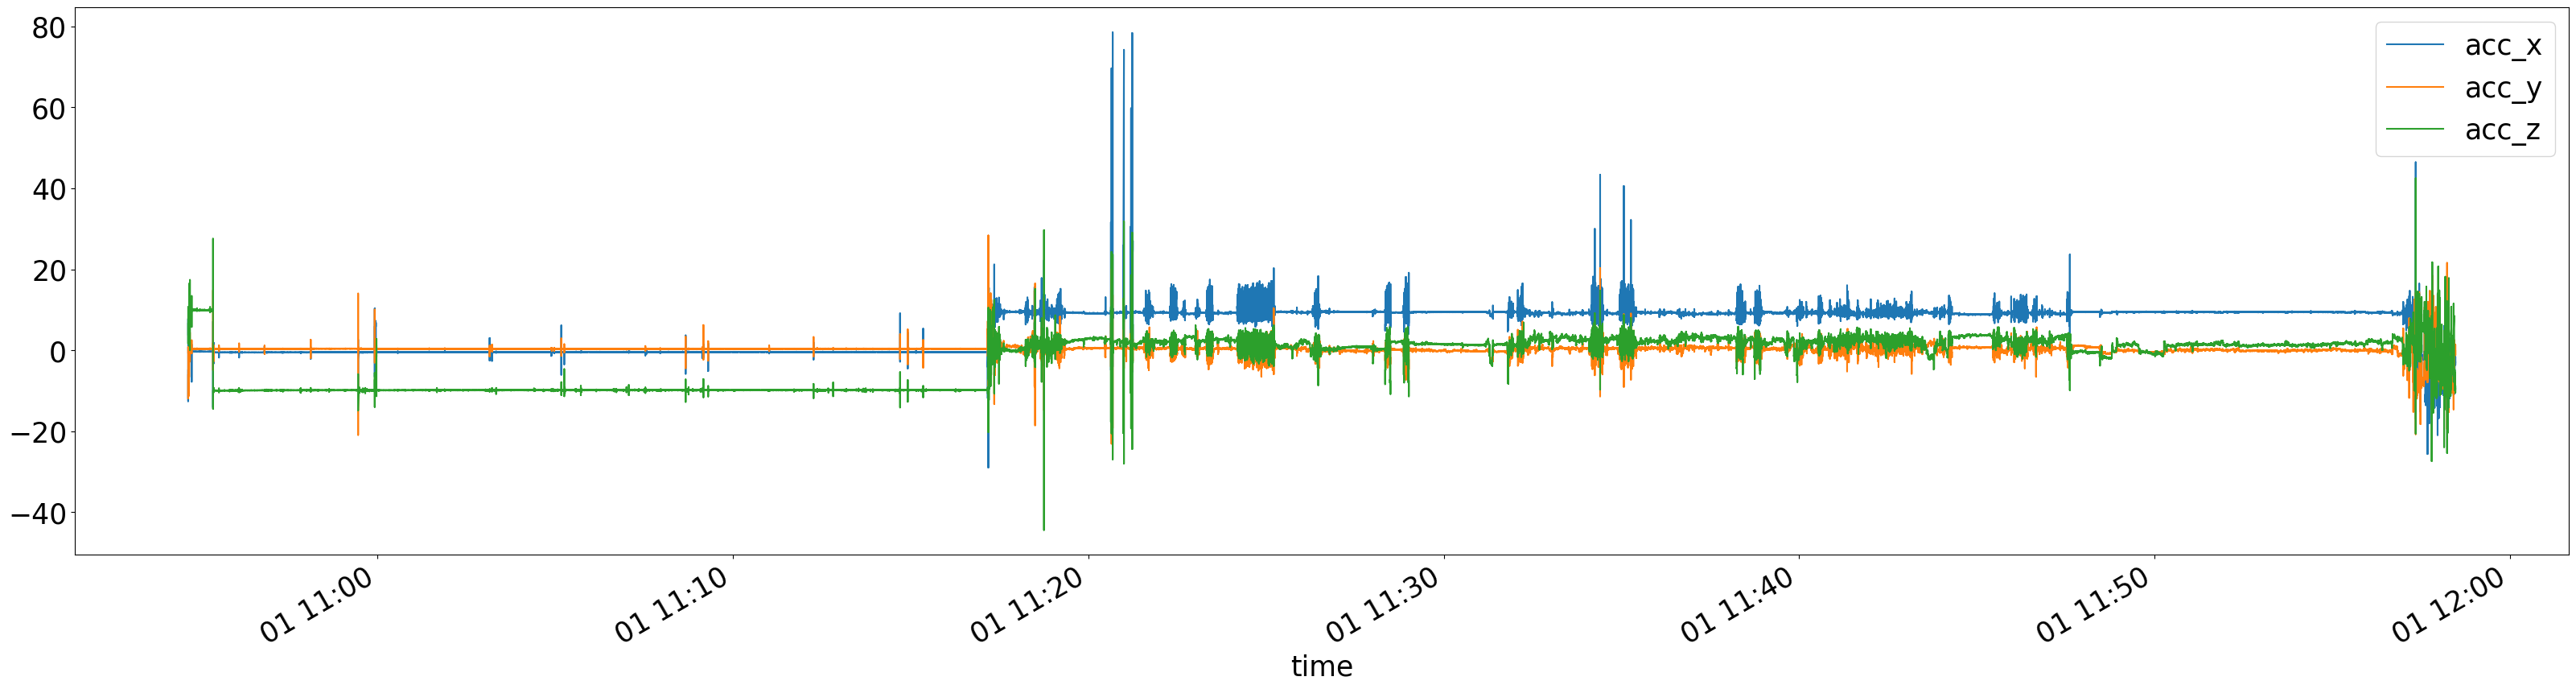

In [44]:
fig_scaler = 10
matplotlib.rcParams.update({'font.size': 2.5*fig_scaler})
single_trial.data_ss.filter(like="acc").plot(figsize=(4*fig_scaler, fig_scaler))
plt.show()